In [ ]:
# person detector for animation
# from 
# https://www.tensorscience.com/object-recognition/person-detection-in-video-streams-using-python-opencv-and-deep-learning

In [8]:
# imports 

from PIL import Image 
from tqdm import tqdm
import shutil
import scipy.ndimage
import numpy as np
import imageio
import matplotlib.pyplot as plt
import os
import cv2
import glob
import imutils

# globals 

# root 
root_path = '/home/linuxdualboot/github/misc projects/lover'

# path for most images 
path = root_path + '/video'

# path for secondary images 
path2 = root_path + '/video2'

# path for tertiary images 
path3 = root_path + '/video3'

# update values everywhere so that this works 
new_frame_rate_change = 0.5

# names of file destinations for images to be overlayed in the future 
contours_ = []
grayed = []

# change to root directory 
os.chdir(root_path)

# shape of video
shape = (0,0,0)

# fps
fps = 0

# all contours 
all_contours = {}

In [16]:
# test individual image, basic functions


# reset the contours 
def reset_contours():
    global all_contours
    all_contours = {}
    
    
# layer images on top of one another 
def dodge(front,back):
    # The formula comes from http://www.adobe.com/devnet/pdf/pdfs/blend_modes.pdf
    result=back*(256.0)/(256.0-front)    
    result[result>255]=255
    result[front==255]=255
    return result.astype('uint8')





def rgba(contours):
    img = img.convert("RGBA")
    datas = img.getdata()

    newData = []
    for item in datas:
        if item[0] == 255 and item[1] == 255 and item[2] == 255:
            newData.append((255, 255, 255, 0))
        else:
            if item[0] > 150:
                newData.append((0, 0, 0, 255))
            else:
                newData.append(item)
                print(item)


    img.putdata(newData)
    img.save("open_science_logo_transparent.png", "PNG")


# not useful rn bc front path colors become diluted 
def blend(front_path, back_path, magnitude, dest_path):
        
    print('Prepping blend... ')
    delete_pics(dest_path)
    
    front, back = [], []
    counter = 0 
    for filename in tqdm(os.listdir(front_path)):
        front.append(np.array(cv2.imread(front_path + '/' + str(counter) + '.jpg')))
        counter += 2
        
    counter = 0
    for filename in tqdm(os.listdir(back_path)):
        back.append(np.array(cv2.imread(back_path + '/' + str(counter) + '.jpg')))
        counter += 2
        
    print('Blending... ')

    os.chdir(dest_path)
    for i in tqdm(range(len(os.listdir(back_path)))):
        
        img1 = Image.fromarray(front[i], 'RGB')
        img2 = Image.fromarray(back[i], 'RGB')
        img_ = Image.blend(img1, img2, magnitude)
        result = np.array(img_)
        
        plt.imsave(dest_path + "/" + str(int(i * 2)) + ".jpg", result, vmin=0, vmax=255)
        
                  
def overlay(path_name, dest_path):
    global all_contours
                  
    print("Overlaying... ")
    if path_name != dest_path:
        delete_pics(dest_path)
                  
    counter = 0
    for filename in tqdm(os.listdir(path_name)):
                  
        img = cv2.imread(path_name + '/' + str(counter) + '.jpg')
                  
#         contours = all_contours[str(counter)]
#         length = len(contours)
#         img = cv2.drawContours(img, contours[:(int)((1/(counter + 1))*length)], -1, (10, 0, 40), 4) 
        img = cv2.drawContours(img, all_contours[str(counter)], -1, (10, 0, 40), 4)


        
        plt.imsave(dest_path + "/" + str(counter) + ".jpg", img, vmin=0, vmax=255)


        counter += 2
                  

# original grayscale formula
def grayscale(rgb):
    return np.dot(rgb, [0.299, 0.587, 0.114])


# time function for contour thickness
def contour_func():
    return 0


# time function for grayscaling 
def gray_func():
    return 0



def find_contour(im):
    image = cv2.imread(im) 

        
    
    # Grayscale 
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 

    # Find Canny edges 
    edged = cv2.Canny(gray, 30, 200) 

    # Finding Contours 
    # Use a copy of the image e.g. edged.copy() 
    # since findContours alters the image 
    contours, hierarchy = cv2.findContours(edged,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE) 
        
    screeCnt = 0
    for c in contours:
        # approximate the contour
    
        epsilon = 0.08 * cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, epsilon, True)

        screeCnt = approx


    return contours, screeCnt     


# create folders, if they don't already exist
def create_folders(path_name):
    try:
        os.mkdir(path_name)
    except OSError:
        print ("Creation of the directory %s failed" % path_name)
    else:
        print ("Successfully created the directory %s " % path_name)

        

# delete photos in a given folder
def delete_pics(path_name):
    for filename in os.listdir(path_name):
        file_path = os.path.join(path_name, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))


# print information about the video to be editted 
def vid_info(vid_name, path_name = root_path):
    global shape 
    global fps
    
    os.chdir(path_name)
    cap = cv2.VideoCapture(vid_name) 
    shape = (int(cap.get(4)), int(cap.get(3)), 3)
    fps = cap.get(cv2.CAP_PROP_FPS)      # OpenCV2 version 2 used "CV_CAP_PROP_FPS"
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = frame_count/fps

    print('fps = ' + str(fps))
    print('number of frames = ' + str(frame_count))
    print('duration (S) = ' + str(duration))
    print('shape = ' + str(shape))

    minutes = int(duration/60)
    seconds = duration%60

    print('duration (M:S) = ' + str(minutes) + ':' + str(seconds))

    cap.release()
    

# go to root path to collect video, break it up into frames and load them into specified folder 

def initialize_frames(vid_name, dest_path, vid_path_name = root_path):
    # go to root path to collect video 
    print('Initializing... ')

    os.chdir(vid_path_name)
    vidcap = cv2.VideoCapture(vid_name)
    success,image = vidcap.read()

    # back to video images path
    os.chdir(dest_path)
    frames = 0
    # write the frames of the video into the video folder according to frame rate variable 
    while success:
        if frames % int(1/new_frame_rate_change) == 0:
            success,image = vidcap.read()
            if success:
                cv2.imwrite("%d.jpg" % frames, image)     # save frame as JPEG file
        else:
            success,image = vidcap.read()
        frames += 1
        
             
def gray(path_name, dest_path):
    # create grayscale and blurred images for video frames 
    print('Graying... ')

    if dest_path != path_name:
        delete_pics(dest_path)

    counter = 0 
    os.chdir(dest_path)

    for filename in tqdm(os.listdir(path_name)):
        img = path_name + "/" + str(counter) + ".jpg"
        s = imageio.imread(img)

        # if counter <= 50:

        if counter < 200:
            new_arr = np.array(s).mean(axis=(2))

            # make this faster by not having to switch axes twice or at all?
            a = [new_arr, new_arr, new_arr]
            r = np.asarray(a).astype(np.uint8)
            r = np.swapaxes(r, 0, 2)
            r = np.swapaxes(r, 0, 1)


            diff = (((counter)/200) * (s - r)).astype(np.uint8)
            r = diff + r 
        else:
            r = s
            
            
#             new_arr = np.array(s).mean(axis=(2))

#             # make this faster by not having to switch axes twice or at all?
#             a = [new_arr, new_arr, new_arr]
#             r = np.asarray(a).astype(np.uint8)
#             r = np.swapaxes(r, 0, 2)
#             r = np.swapaxes(r, 0, 1)

        
        plt.imsave(dest_path + "/" + str(counter) + ".jpg", r, vmin=0, vmax=255)
        
        # need?
        grayed.append(path_name +"/" + filename)

        counter += 2
        
def blur(path_name, dest_path, sigma, inverse = True):
    # create grayscale and blurred images for video frames
    print('Blurring... ')

    if dest_path != path_name:
        delete_pics(dest_path)

        
    counter = 0 
    os.chdir(dest_path)

    for filename in tqdm(os.listdir(path_name)):
        img = path_name + "/" + str(counter) + ".jpg"

        s = imageio.imread(img)

        if (inverse):
            i = (255)-s
            b = scipy.ndimage.filters.gaussian_filter(i,sigma=sigma)
        else:
            b = scipy.ndimage.filters.gaussian_filter(s,sigma=sigma)

        r = dodge(s,b)

        plt.imsave(dest_path + "/" + str(counter) + ".jpg", r, vmin=0, vmax=255)

        counter += 2
    

# create gray frames 
def gray_n_blur(path_name, dest_path):
    # create grayscale and blurred images for video frames 
    
    if dest_path != path_name:
        delete_pics(dest_path)

        
    counter = 0 
    os.chdir(dest_path)

    for filename in tqdm(os.listdir(path_name)):
        img = path_name + "/" + str(counter) + ".jpg"

        s = imageio.imread(img)

        if counter > 1000:

            # make this faster by not having to switch axes twice or at all?
            a = [new_arr, new_arr, new_arr]
            r = np.asarray(a).astype(np.uint8)
            r = np.swapaxes(r, 0, 2)
            r = np.swapaxes(r, 0, 1)


            diff = (((counter)/50) * (s - r)).astype(np.uint8)
            r = diff + r 


            i = (255)-r
            b = scipy.ndimage.filters.gaussian_filter(i,sigma=5)
            r = dodge(r,b)
        else:
            #delete
            new_arr = np.array(s).mean(axis=(2))

            a = [new_arr, new_arr, new_arr]
            r = np.asarray(a).astype(np.uint8)
            r = np.swapaxes(r, 0, 2)
            r = np.swapaxes(r, 0, 1)
            
            
            
            i = (255)-r
            # b = scipy.ndimage.filters.gaussian_filter(i,sigma=5 % (counter+1) + 3)
            b = scipy.ndimage.filters.gaussian_filter(i,sigma=10)
            r = dodge(r,b)


        
        plt.imsave(dest_path + "/" + str(counter) + ".jpg", r, vmin=0, vmax=255)
        
        # need?
        grayed.append(path_name +"/" + filename)

        counter += 2


def fContours(vid_name, path_name, dest_path, writeIm = True):
    global all_contours 
    print('Contouring... ')

    # find contour images 
    
    if dest_path != path_name:
        delete_pics(dest_path)

    counter = 0
    os.chdir(dest_path)
    
    
    for filename in tqdm(os.listdir(path_name)):
        
        contours, screeCnt = find_contour(path_name + "/" + str(counter) + ".jpg")
        
        all_contours[str(counter)] = contours
        if writeIm:
            # a white backdrop the same size as the rest of video
            white = np.full(shape, 255, dtype=np.uint8)

            # Draw all contours 
            # -1 signifies drawing all contours 
            # img = cv2.drawContours(white, contours, -1, (10, 0, 40), int((counter/2)) % 3 + 1) 
            img = cv2.drawContours(white, contours, -1, (10, 0, 40), 2) 
            plt.imsave(dest_path + "/" + str(counter) + ".jpg", img, vmin=0, vmax=255)
            contours_.append(dest_path +'/' + str(counter) + '.jpg')
        counter += 2
        
        
        
def final_vid(path_name):
    # combine frames into a final video 

    img_array_sorted = []
    counter = 0 

    print('Putting everything together... ')
    for filename in tqdm(os.listdir(path_name)):

        img = cv2.imread(path_name + "/" + str(counter) + ".jpg")
        try:
            height, width, layers = img.shape
            size = (width,height)
            img_array_sorted.append(img)
        except:
            pass
        counter += int(1/new_frame_rate_change)


    os.chdir(root_path)
    out = cv2.VideoWriter('project.mp4',cv2.VideoWriter_fourcc(*'DIVX'), int(fps*new_frame_rate_change), size)

    for i in range(len(img_array_sorted)):
        out.write(img_array_sorted[i])
    out.release()
    
    
    
def test_image():
    # test image 
    img ="picture.jpg"

    # read image 
    s = imageio.imread(img)

    # delete
    g = grayscale(s)

    # take average of rgb values down the z axis instead of grayscale function 
    new_arr = np.array(s).mean(axis=(2))


    # create ndarray for image (three of the average ndarrays, with axes swapped)
    # make this faster by not having to switch axes?
    a = [new_arr, new_arr, new_arr]
    arr1 = np.asarray(a).astype(np.uint8)
    arr1 = np.swapaxes(arr1, 0, 2)
    arr1 = np.swapaxes(arr1, 0, 1)
    
    # diff = (s - arr1).astype(np.uint8)
    # arr1 = diff + arr1



    # inverse
    i = 255 - arr1

    # blur the inverse, higher sigma = more run time + deeper blur 
    b = scipy.ndimage.filters.gaussian_filter(i,sigma=5)

    # combine 
    r = dodge(b,arr1)


    # display 
    %matplotlib inline 
    plt.imshow(r)


def reset():
    delete_pics(path)
    delete_pics(path2)
    delete_pics(path3)
    reset_contours()
    os.chdir(root_path)

In [17]:
# import the necessary packages
import numpy as np
import cv2
 
# initialize the HOG descriptor/person detector
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

cv2.startWindowThread()

# open webcam video stream
cap = cv2.VideoCapture("video.mp4") 

# the output will be written to output.avi
shape = (int(cap.get(3)), int(cap.get(4)))
fps = cap.get(cv2.CAP_PROP_FPS)      # OpenCV2 version 2 used "CV_CAP_PROP_FPS"
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))


out = cv2.VideoWriter('project2.mp4',cv2.VideoWriter_fourcc(*'DIVX'), int(fps), shape)


while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()
    
    if frame is None:
        break

    # resizing for faster detection
    frame = cv2.resize(frame, shape)
    # using a greyscale picture, also for faster detection
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

    # detect people in the image
    # returns the bounding boxes for the detected objects
    boxes, weights = hog.detectMultiScale(frame, winStride=(8,8) )

    boxes = np.array([[x, y, x + w, y + h] for (x, y, w, h) in boxes])

    for (xA, yA, xB, yB) in boxes:
        # display the detected boxes in the colour picture
        cv2.rectangle(frame, (xA, yA), (xB, yB),
                          (0, 255, 0), 2)
    
    # Write the output video 
    out.write(frame)

    
# and release the output
out.release()
# When everything done, release the capture
cap.release()
# finally, close the window
cv2.destroyAllWindows()


array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

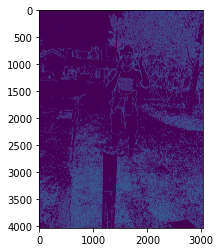

In [21]:
def auto_canny(image, sigma=0.33):
    # compute the median of the single channel pixel intensities
    v = np.median(image)
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)
    # return the edged image
    return edged

def find_edge(im):
    image = cv2.imread(im)

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    blurred = cv2.GaussianBlur(gray, (3, 3), 0)

    
    # apply Canny edge detection using a wide threshold, tight
    # threshold, and automatically determined threshold

    auto = auto_canny(blurred)
    plt.imshow(auto)


    return auto
os.chdir(root_path)
find_edge('picture.jpg')

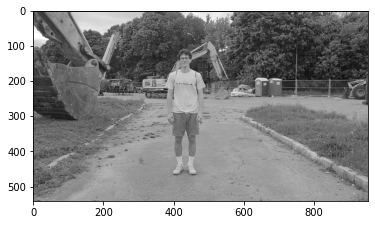

In [163]:
s = imageio.imread('1.png')
new_arr = np.array(s).mean(axis=(2))
shape = new_arr.shape
white = np.full((shape[0], shape[1], 3), 255, dtype=np.uint8)

# make this faster by not having to switch axes twice or at all?
a = [new_arr, new_arr, new_arr]
r = np.asarray(a).astype(np.uint8)
r = np.swapaxes(r, 0, 2)
r = np.swapaxes(r, 0, 1)

plt.imshow(r)

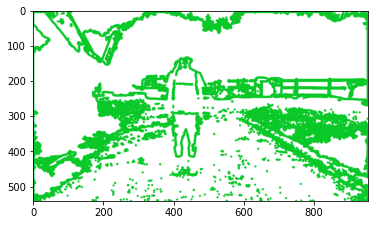

In [187]:


white = np.full((shape[0], shape[1], 3), 255, dtype=np.uint8)


i = (255)-r
b = scipy.ndimage.filters.gaussian_filter(i,sigma=3)
r = dodge(r,b)


imgray = cv2.cvtColor(s, cv2.COLOR_BGR2GRAY)


ret, thresh = cv2.threshold(imgray, 120, 120, 140)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)



p = cv2.drawContours(white, contours, -1, (10, 200, 40), 5)

plt.imshow(p)

In [159]:
img = img.convert("RGBA")
datas = img.getdata()
plt.imshow(img)


newData = []
for item in datas:
    if item[0] == 255 and item[1] == 255 and item[2] == 255:
        newData.append((255, 255, 255, 0))
    else:
        newData.append(item)
        
                    
img.putdata(newData)
plt.imshow(img)
    

AttributeError: 'numpy.ndarray' object has no attribute 'convert'